In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

import cometToolkit as comets
import cometToolkit as ctk

from astropy.nddata import Cutout2D

# Investigating Background Subtraction

105241976.73913015


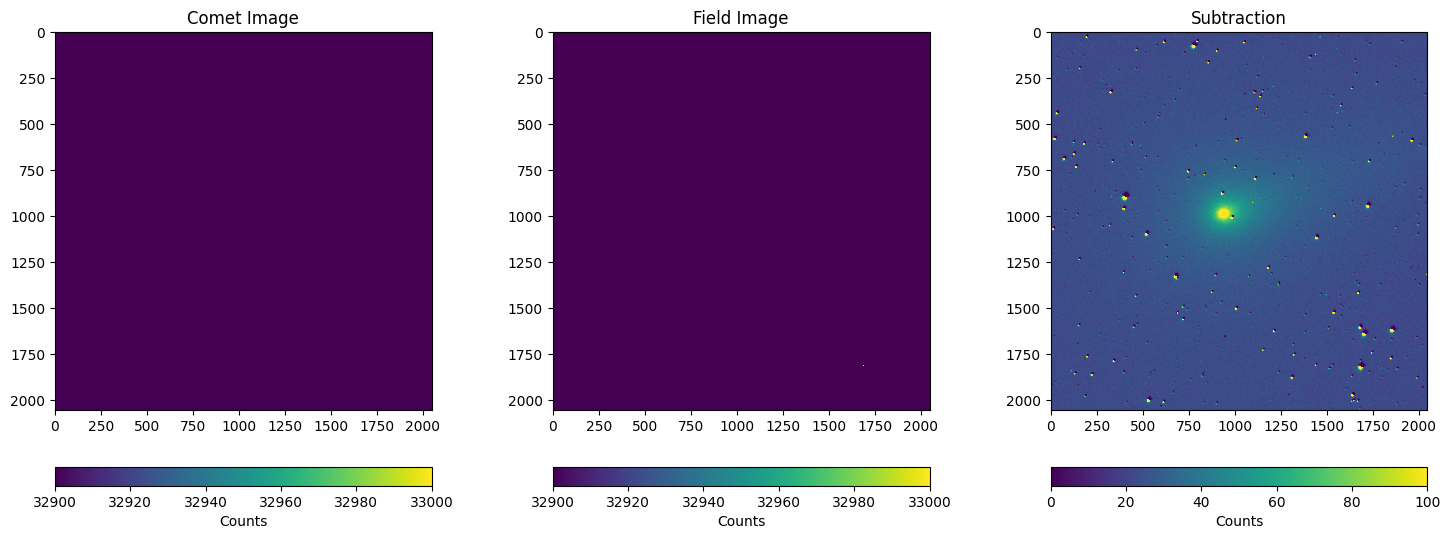

In [6]:
cometImage = ctk.GetImage("../DataProducts/ReducedImages/Day01/V/Comet62P_V00.fits")
backgroundImage = ctk.GetImage("../DataProducts/ReducedImages/Day01/V/Field_V00.fits")

print(np.sum(cometImage - backgroundImage))

#backgroundImage = np.roll(backgroundImage, (-5, 7), axis=(1,0))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(cometImage, vmin=32900, vmax=33000)
im1 = axes[1].imshow(backgroundImage, vmin=32900, vmax=33000)
im2 = axes[2].imshow(cometImage - backgroundImage, vmin=0, vmax=100)

axes[0].set_title("Comet Image")
axes[1].set_title("Field Image")
axes[2].set_title("Subtraction")

ims = [im0, im1, im2]
for i, ax in enumerate(axes):
    cax = ax.inset_axes([0, -0.2, 1, 0.05])
    plt.colorbar(ims[i], cax=cax, orientation="horizontal", label="Counts")

#plt.colorbar(im)

plt.tight_layout()

# Image Stacking

### Star Stacking

In [17]:
stackedVField = ctk.StackImages(glob("../DataProducts/ReducedImages/Day01/V/Field_V0*.fits"))
stackedVField = ctk.RollImage(stackedVField, (-4, 7))
ctk.SaveFits(stackedVField, "../DataProducts/ReducedImages/Day01/V/stackedField_V.fits")

FITS image saved to: ../DataProducts/ReducedImages/Day01/V/stackedField_V.fits


### Comet Stacking

In [ ]:
rootPath = "/home/daraghhollman/Main/CometsThesis/"

path="Data/cometData01/"

dataPaths = natsorted(glob(rootPath + path + "*.fits"))

vDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 354) % 3 == 0]
rDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 355) % 3 == 0]
bDataPaths = [ path for path in dataPaths if ( int(path.split("_")[-1][:-5]) - 356) % 3 == 0]
print(vDataPaths)
print(rDataPaths)
print(bDataPaths)

['/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0354.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0357.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0360.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0363.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0366.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0369.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0372.fits']
['/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0355.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0358.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0361.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0364.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0367.fits', '/home/daraghhollman/Main/CometsThesis/Data/cometData01/ucdA_0370.fits', '/home/daraghhollman/Main/CometsThesis/Data/comet

##### Basic Plotting

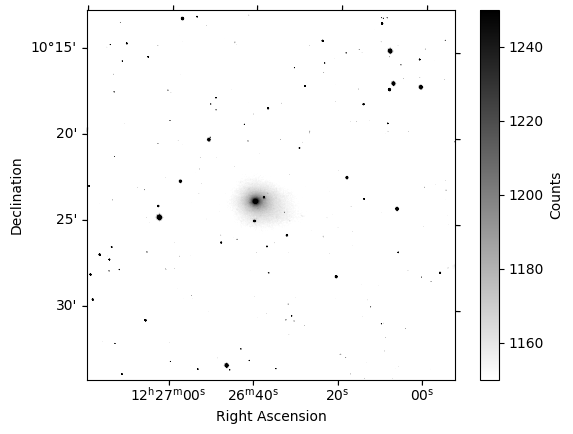

In [60]:
# V band min and max: vmin=1150, vmax =1250

comets.PlotFits(vDataPaths[0], wcsPath=rootPath + "Data/wcs/tsuchinshanWCS.fits",
                vmin=1150, vmax =1250)

wcs = WCS(fits.open(rootPath + "Data/wcs/tsuchinshanWCS.fits")[0].header)

#### Finding the optocentre

In [2]:
import cometToolkit as ctk
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob

vReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/V/*"))[:-2]
rReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/R/*"))[:-2]
bReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/B/*"))[:-2]

print(bReducedDataPaths)

['../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B00.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B01.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B02.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B03.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B04.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B05.fits', '../../Python/DataProducts/ReducedImages/Day01/B/Comet62P_B06.fits']


(983.1843977343415, 1009.9592708787802)

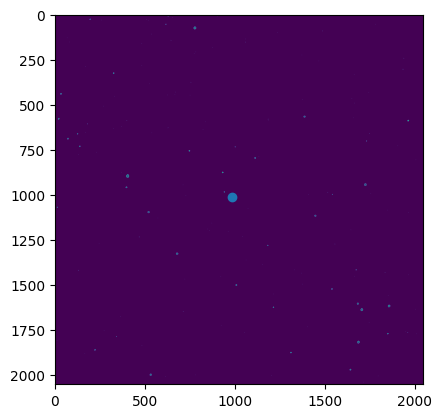

In [48]:
ctk.FindCometCentre(bReducedDataPaths[0], filter="B", showPlot=True, maxCentreDistance=100)

In [4]:
def StackImages(paths, filter, bounds):
    stackingImages = []

    cutouts = []

    for path in paths:
        image = fits.open(path)[0].data

        centre = comets.FindCometCentre(path, filter, maxCentreDistance=200)

        # Create new fits file centred on the comet
        cutout = Cutout2D(image, (centre[0], centre[1]), (bounds[1] - bounds[0]), wcs=wcs)

        cutouts.append(cutout)

    cutoutWcs = cutouts[0].wcs
    for cutout in cutouts:
        stackingImages.append(np.array(cutout.data))
    
    print(np.shape(stackingImages))

    stackedImage = np.median(stackingImages, axis=0) * np.sqrt(len(paths))

    return stackedImage, cutoutWcs

In [5]:
wcs = WCS(fits.open("../../Data/wcs/tsuchinshanWCS.fits")[0].header)

vStackedImage, cutoutWcs = StackImages(vReducedDataPaths, "V", [100, 2054-100])

(7, 1854, 1854)


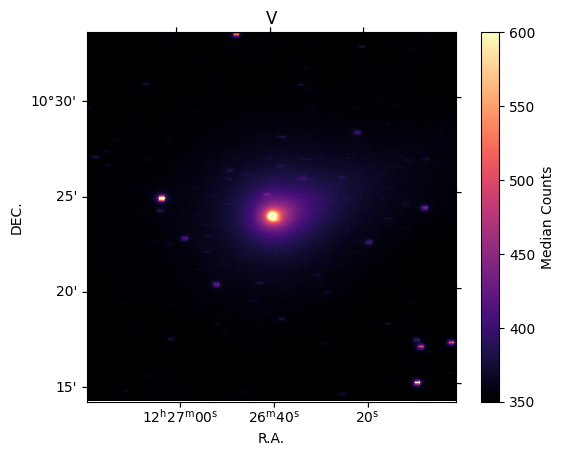

In [24]:
plt.subplot(projection=cutoutWcs)
plt.imshow(vStackedImage, cmap="magma", vmin=350, vmax=600)
plt.colorbar(label="Median Counts")
plt.title("V")
plt.xlabel("R.A.")
plt.ylabel("DEC.")
plt.gca().invert_yaxis()

In [8]:
rStackedImage, _ = StackImages(rReducedDataPaths, "R", [100, 2054-100])

(7, 1854, 1854)


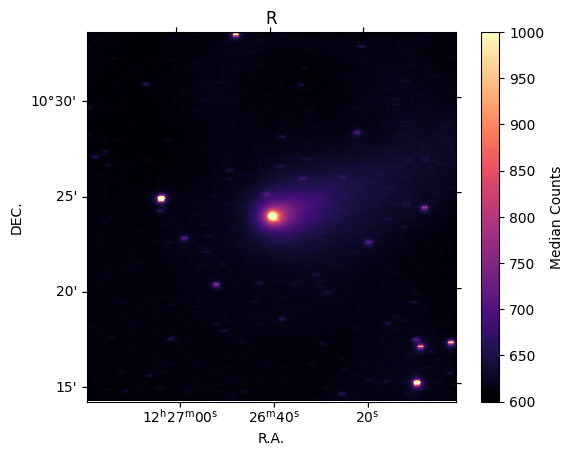

In [15]:
plt.subplot(projection=cutoutWcs)
plt.imshow(rStackedImage, cmap="magma", vmin=600, vmax=1000)
plt.colorbar(label="Median Counts")
plt.title("R")
plt.xlabel("R.A.")
plt.ylabel("DEC.")
plt.gca().invert_yaxis()

In [25]:
bStackedImage, _ = StackImages(bReducedDataPaths, "B", [100, 2054-100])

(7, 1854, 1854)


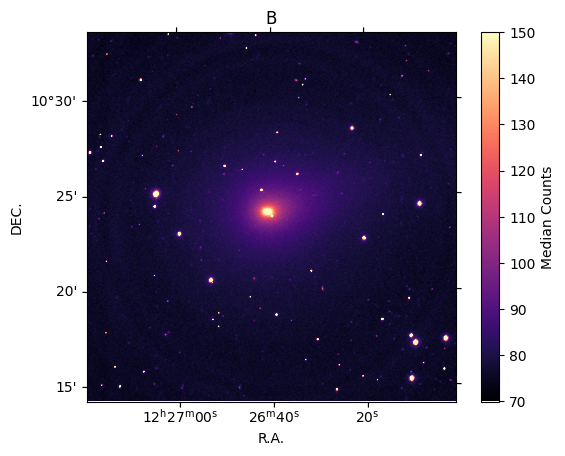

In [31]:
plt.subplot(projection=cutoutWcs)
plt.imshow(bStackedImage, cmap="magma", vmin=70, vmax=150)
plt.colorbar(label="Median Counts")
plt.title("B")
plt.xlabel("R.A.")
plt.ylabel("DEC.")
plt.gca().invert_yaxis()

In [49]:
comets.SaveFits(vStackedImage, "../DataProducts/vStacked.fits")
comets.SaveFits(rStackedImage, "../DataProducts/rStacked.fits")
comets.SaveFits(bStackedImage, "../DataProducts/bStacked.fits")

3289.089173500308
3289.089173500308
FITS image saved to: ../DataProducts/vStacked.fits
5839.1073084489235
5839.1073084489235
FITS image saved to: ../DataProducts/rStacked.fits
139985.52916610538
139985.52916610538
FITS image saved to: ../DataProducts/bStacked.fits


(500.0, 700.0)

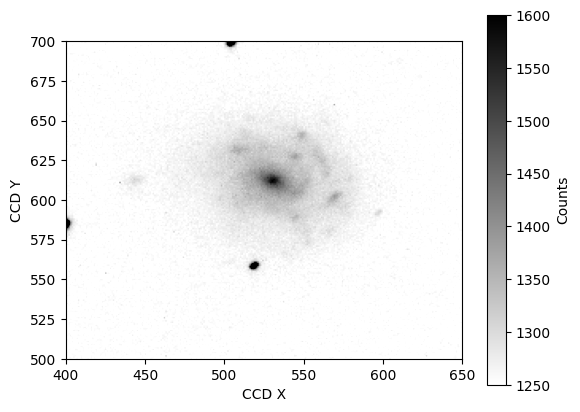

In [57]:
ctk.PlotFits("../../Data/cometData02/ucdA_0458.fits", vmin=1250, vmax=1600)

# B: vmin=1020, vmax=1100
# V: vmin=1120, vmax=1400
# R: vmin=1250, vmax=1600

plt.xlim(400, 650)
plt.ylim(500, 700)